# loading of dataset

In [1]:
import tensorflow as tf
dataset_dir = "C:\Plant_leave_diseases_dataset_without_augmentation"
  
batch_size = 32                 
img_size = (224, 224)            

dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',               
    label_mode='categorical',       
    color_mode='rgb',                
    batch_size=batch_size,
    image_size=img_size,             
    shuffle=True                    
)

for images, labels in dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)


Found 24164 files belonging to 17 classes.
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 17)


In [2]:
class_names = dataset.class_names
print("Class names:", class_names)

Class names: ['Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


# Dataset splitting

In [3]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()


train_size = int(0.8 * dataset_size) 
val_size = int(0.1 * dataset_size)    
test_size = dataset_size - train_size - val_size  


train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)

val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)


train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")
print(f"Test dataset size: {test_size}")


Total dataset size: 756
Train dataset size: 604
Validation dataset size: 75
Test dataset size: 77


# vgg16

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


base_model_16 = keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(160, 160, 3) 
)

base_model_16.trainable = False


inputs = keras.Input(shape=(160, 160, 3))  
x = base_model_16(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)  
x = layers.BatchNormalization()(x)  
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)  
x = layers.Dropout(0.4)(x)  
outputs = layers.Dense(17, activation="softmax")(x)  

model_16 = keras.Model(inputs, outputs)



In [4]:
model_16.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [5]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [6]:
history = model_16.fit(
    train_dataset,
    epochs=80,  
    validation_data=val_dataset,
    callbacks=[early_stopping]
)


Epoch 1/80
604/604 ━━━━━━━━━━━━━━━━━━━━ 3188s 5s/step - accuracy: 0.2785 - loss: 4.5222 - val_accuracy: 0.7083 - val_loss: 2.8088
Epoch 2/80
604/604 ━━━━━━━━━━━━━━━━━━━━ 3099s 5s/step - accuracy: 0.6538 - loss: 2.8304 - val_accuracy: 0.7900 - val_loss: 2.2179
Epoch 3/80
604/604 ━━━━━━━━━━━━━━━━━━━━ 3112s 5s/step - accuracy: 0.7351 - loss: 2.2676 - val_accuracy: 0.8183 - val_loss: 1.8310
Epoch 4/80
604/604 ━━━━━━━━━━━━━━━━━━━━ 3111s 5s/step - accuracy: 0.7805 - loss: 1.8762 - val_accuracy: 0.8492 - val_loss: 1.5170
Epoch 5/80
604/604 ━━━━━━━━━━━━━━━━━━━━ 3076s 5s/step - accuracy: 0.8109 - loss: 1.5562 - val_accuracy: 0.8633 - val_loss: 1.2805
Epoch 6/80
604/604 ━━━━━━━━━━━━━━━━━━━━ 3013s 5s/step - accuracy: 0.8298 - loss: 1.3190 - val_accuracy: 0.8704 - val_loss: 1.0874
Epoch 7/80
604/604 ━━━━━━━━━━━━━━━━━━━━ 3027s 5s/step - accuracy: 0.8440 - loss: 1.1265 - val_accuracy: 0.8838 - val_loss: 0.9337
Epoch 8/80
604/604 ━━━━━━━━━━━━━━━━━━━━ 3020s 5s/step - accuracy: 0.8629 - loss: 0.9708 - 

In [16]:
train_loss, train_accuracy = model_16.evaluate(train_dataset, verbose=1)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

604/604 ━━━━━━━━━━━━━━━━━━━━ 2735s 5s/step - accuracy: 0.9773 - loss: 0.1899
Train Accuracy: 97.80%


In [17]:
val_loss, val_accuracy = model_16.evaluate(val_dataset, verbose=1)
print(f"validation Accuracy: {val_accuracy * 100:.2f}%")

75/75 ━━━━━━━━━━━━━━━━━━━━ 355s 5s/step - accuracy: 0.9339 - loss: 0.2829
validation Accuracy: 92.83%


In [10]:
test_loss, test_accuracy = model_16.evaluate(test_dataset, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

77/77 ━━━━━━━━━━━━━━━━━━━━ 372s 5s/step - accuracy: 0.9382 - loss: 0.2879
Test Accuracy: 93.51%


In [7]:
model_16.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 5, 5, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 17)                  │           2,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,922,357 (56.92 MB)

 Trainable params: 68,881 (269.07 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

 Optimizer params: 137,764 (538.14 KB)

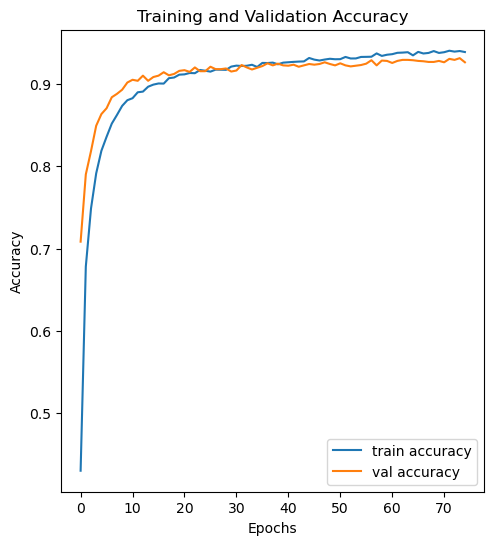

In [12]:
# Accuracy Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

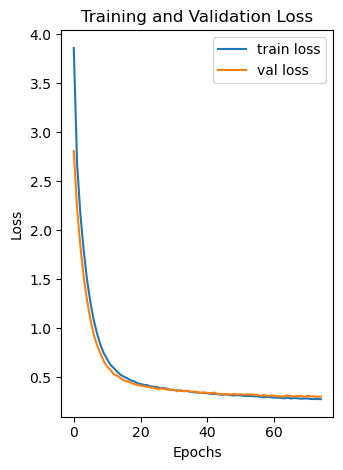

In [13]:
# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Predict the labels
y_true_16 = []
y_pred_16 = []

for images, labels in test_dataset:
    y_true_16.extend(np.argmax(labels.numpy(), axis=1)) 
    predictions_16 = model_16.predict(images)
    y_pred_16.extend(np.argmax(predictions_16, axis=1)) 

cm_16 = confusion_matrix(y_true_16, y_pred_16)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 

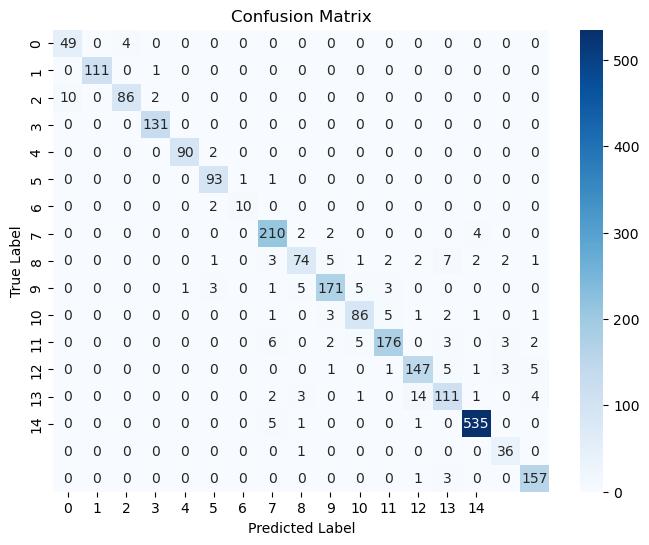

In [11]:
import matplotlib.pyplot as plt
cm_16 = confusion_matrix(y_true_16, y_pred_16)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_16, annot=True, fmt="d", cmap="Blues", xticklabels=range(15), yticklabels=range(15))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# class balance

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def get_class_distribution(dataset):
    labels = []
    for _, label in dataset:  
        label = label.numpy()  
        if label.ndim > 0:  
            label = label.argmax()  
        labels.append(label)

    class_counts = Counter(labels)  
    return class_counts


class_counts = get_class_distribution(train_dataset)


print("Class Distribution:", class_counts)

Class Distribution: Counter({14: 136, 9: 48, 16: 45, 7: 43, 12: 43, 11: 39, 2: 34, 3: 34, 8: 31, 4: 30, 13: 29, 1: 26, 10: 21, 5: 21, 0: 15, 15: 8, 6: 1})


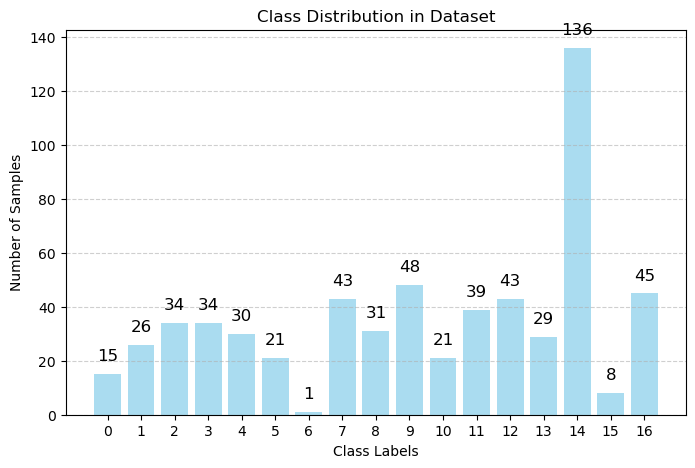

In [5]:
def plot_class_distribution(class_counts):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(8, 5))
    plt.bar(classes, counts, color='skyblue', alpha=0.7)
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Samples")
    plt.title("Class Distribution in Dataset")
    plt.xticks(classes)
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    for i, count in enumerate(counts):
        plt.text(classes[i], count + 5, str(count), ha="center", fontsize=12)

    plt.show()

plot_class_distribution(class_counts)

class weights

In [22]:
import numpy as np
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

all_labels = []

for _, label in train_dataset:
    label = label.numpy()

   
    if isinstance(label, np.ndarray) and label.ndim > 1:
        label = np.argmax(label)  
    
    all_labels.append(int(label)) 

all_labels = np.array(all_labels).flatten()

class_labels = np.unique(all_labels)  
print("Detected Classes:", class_labels)  

class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=all_labels)

class_weight_dict = {class_labels[i]: class_weights[i] for i in range(len(class_labels))}
print("Computed Class Weights:", class_weight_dict)


Detected Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Computed Class Weights: {0: 2.368627450980392, 1: 1.1102941176470589, 2: 1.4803921568627452, 3: 0.888235294117647, 4: 1.6149732620320856, 5: 1.26890756302521, 6: 17.764705882352942, 7: 0.9602543720190779, 8: 1.6149732620320856, 9: 0.7559449311639549, 10: 1.4803921568627452, 11: 0.9110105580693816, 12: 0.888235294117647, 13: 0.9110105580693816, 14: 0.24845742492801318, 15: 3.947712418300654, 16: 0.866571018651363}


# data augmentation

In [14]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),  
    RandomRotation(0.2),  
    RandomZoom(0.2),  
])

In [15]:
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# resnet50

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

In [28]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output) 
x = Dense(256, activation="relu")(x)           
x = Dropout(0.4)(x)                             
x = Dense(128, activation="relu")(x)            
x = Dropout(0.3)(x)                             
output_layer = Dense(17, activation="softmax")(x)  


model = Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [29]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_accuracy", patience=3, factor=0.5, min_lr=1e-6)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=30, 
                    class_weight=class_weights, callbacks=[early_stopping, lr_scheduler])


Epoch 1/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 2243s 4s/step - accuracy: 0.3118 - loss: 2.3634 - val_accuracy: 0.7663 - val_loss: 0.8068 - learning_rate: 1.0000e-04
Epoch 2/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 2202s 4s/step - accuracy: 0.6647 - loss: 1.1073 - val_accuracy: 0.8242 - val_loss: 0.5487 - learning_rate: 1.0000e-04
Epoch 3/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 2209s 4s/step - accuracy: 0.7540 - loss: 0.7767 - val_accuracy: 0.8583 - val_loss: 0.4444 - learning_rate: 1.0000e-04
Epoch 4/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 2207s 4s/step - accuracy: 0.8040 - loss: 0.6281 - val_accuracy: 0.8558 - val_loss: 0.4124 - learning_rate: 1.0000e-04
Epoch 5/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 2210s 4s/step - accuracy: 0.8348 - loss: 0.5195 - val_accuracy: 0.8788 - val_loss: 0.3590 - learning_rate: 1.0000e-04
Epoch 6/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 2210s 4s/step - accuracy: 0.8506 - loss: 0.4656 - val_accuracy: 0.8813 - val_loss: 0.3542 - learning_rate: 1.0000e-04
Epoch 7/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 2208s 4s/ste

In [30]:
# Unfreeze Top 50% of ResNet50 Layers
for layer in base_model.layers[-50:]:
    layer.trainable = True

# againCompilewith a Lower Learning Rate
model.compile(optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Fine-Tune the Model
history_fine = model.fit(train_dataset, validation_data=val_dataset, epochs=30, 
                         class_weight=class_weights, callbacks=[early_stopping, lr_scheduler])


Epoch 1/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 3798s 6s/step - accuracy: 0.7868 - loss: 0.7153 - val_accuracy: 0.9237 - val_loss: 0.2319 - learning_rate: 1.0000e-05
Epoch 2/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 3762s 6s/step - accuracy: 0.9067 - loss: 0.3070 - val_accuracy: 0.9337 - val_loss: 0.1943 - learning_rate: 1.0000e-05
Epoch 3/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 3734s 6s/step - accuracy: 0.9255 - loss: 0.2309 - val_accuracy: 0.9362 - val_loss: 0.1774 - learning_rate: 1.0000e-05
Epoch 4/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 3746s 6s/step - accuracy: 0.9349 - loss: 0.2016 - val_accuracy: 0.9475 - val_loss: 0.1541 - learning_rate: 1.0000e-05
Epoch 5/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 3720s 6s/step - accuracy: 0.9485 - loss: 0.1654 - val_accuracy: 0.9546 - val_loss: 0.1346 - learning_rate: 1.0000e-05
Epoch 6/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 3728s 6s/step - accuracy: 0.9514 - loss: 0.1567 - val_accuracy: 0.9596 - val_loss: 0.1202 - learning_rate: 1.0000e-05
Epoch 7/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 3717s 6s/ste

In [31]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")


77/77 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.9679 - loss: 0.1088
Test Accuracy: 0.9745


In [33]:
train_loss, train_acc = model.evaluate(train_dataset)
print(f"Train Accuracy: {train_acc:.4f}")

604/604 ━━━━━━━━━━━━━━━━━━━━ 2019s 3s/step - accuracy: 0.9951 - loss: 0.0163
Train Accuracy: 0.9959


In [34]:
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_acc:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.9824 - loss: 0.0702
Validation Accuracy: 0.9812


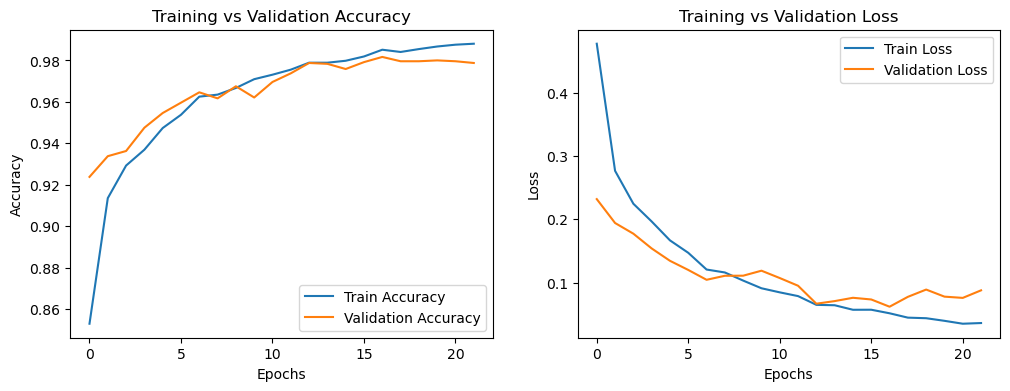

In [32]:
def plot_metrics(history):
    plt.figure(figsize=(12, 4))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.show()

plot_metrics(history_fine)


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

true_labels = []
pred_labels = []

for images, labels in test_dataset:  
    preds = model.predict(images)  
    pred_classes = np.argmax(preds, axis=1)  
    true_classes = np.argmax(labels.numpy(), axis=1) 
    
    true_labels.extend(true_classes)
    pred_labels.extend(pred_classes)

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

cm = confusion_matrix(true_labels, pred_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

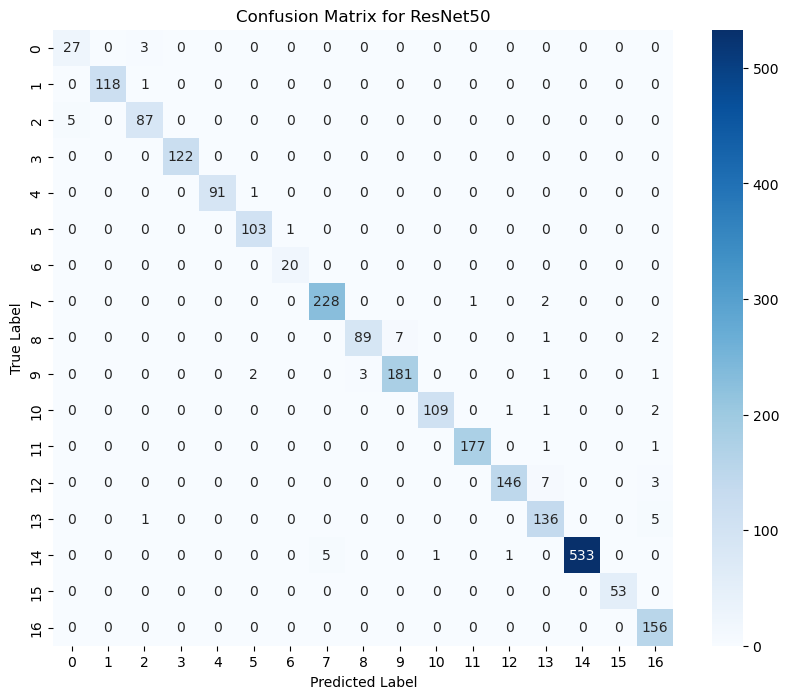

In [36]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(17), yticklabels=range(17))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for ResNet50")
plt.show()

In [37]:
#classification report
class_names = [f"Class {i}" for i in range(17)] 
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.84      0.90      0.87        30
     Class 1       1.00      0.99      1.00       119
     Class 2       0.95      0.95      0.95        92
     Class 3       1.00      1.00      1.00       122
     Class 4       1.00      0.99      0.99        92
     Class 5       0.97      0.99      0.98       104
     Class 6       0.95      1.00      0.98        20
     Class 7       0.98      0.99      0.98       231
     Class 8       0.97      0.90      0.93        99
     Class 9       0.96      0.96      0.96       188
    Class 10       0.99      0.96      0.98       113
    Class 11       0.99      0.99      0.99       179
    Class 12       0.99      0.94      0.96       156
    Class 13       0.91      0.96      0.93       142
    Class 14       1.00      0.99      0.99       540
    Class 15       1.00      1.00      1.00        53
    Class 16       0.92      1.00      0.96       156

  

In [38]:
model.save("resnet50model.h5")